In [1]:
"""
# Elastic Net Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

Elastic Net combines L1 (Lasso) and L2 (Ridge) penalties:
- **alpha:** Total regularization strength
- **l1_ratio:** Balance between L1 and L2 (0 = pure Ridge, 1 = pure Lasso)
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing and evaluation function
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([
    ('scaler', StandardScaler()),
])


def fit_eval(alpha: float, l1_ratio: float) -> dict:
    """Train Elastic Net with given hyperparameters."""
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=50000)
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    coef = np.asarray(pipe.named_steps['model'].coef_)
    nnz = int(np.sum(np.abs(coef) > 1e-12))
    
    return {
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'nonzero_coef': nnz,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 2D Grid Search: alpha × l1_ratio
# ─────────────────────────────────────────────────────────────────────────────
alphas = np.logspace(-4, 1, 20)
l1_ratios = np.linspace(0.0, 1.0, 11)

rows = []
for a in alphas:
    for r in l1_ratios:
        rows.append(fit_eval(float(a), float(r)))

res = pd.DataFrame(rows)

# Best result
best = res.loc[res['r2_adj_test'].idxmax()]
print(f"\nBest configuration:")
print(f"  alpha = {best['alpha']:.2e}, l1_ratio = {best['l1_ratio']:.2f}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Non-zero coefficients: {int(best['nonzero_coef'])}/{len(feature_cols)}")

res[['alpha', 'l1_ratio', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'nonzero_coef']].sort_values('r2_adj_test', ascending=False).head(10)

c:\Users\karth\miniconda3\envs\airfoilai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.101e+04, tolerance: 5.565e+01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\karth\miniconda3\envs\airfoilai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.102e+04, tolerance: 5.565e+01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in skl


Best configuration:
  alpha = 4.83e-01, l1_ratio = 0.90
  Train R² adj = 0.6650
  Test R² adj  = 0.5888
  RMSE (test)  = 21.18
  Non-zero coefficients: 5/5


c:\Users\karth\miniconda3\envs\airfoilai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+05, tolerance: 5.565e+01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\karth\miniconda3\envs\airfoilai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e+05, tolerance: 5.565e+01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in skl

,alpha,l1_ratio,r2_adj_train,r2_adj_test,rmse_test,nonzero_coef
163,0.483293,0.9,0.664952,0.588824,21.178360,5
150,0.263665,0.7,0.663658,0.588754,21.180173,5
137,0.143845,0.5,0.665004,0.588747,21.180344,5
151,0.263665,0.8,0.665870,0.588718,21.181086,5
121,0.078476,0.0,0.664805,0.588683,21.181995,5
136,0.143845,0.4,0.663734,0.588669,21.182355,5
122,0.078476,0.1,0.665444,0.588656,21.182693,5
138,0.143845,0.6,0.666108,0.588601,21.184108,5
123,0.078476,0.2,0.666032,0.588561,21.185145,5
124,0.078476,0.3,0.666568,0.588394,21.189433,5


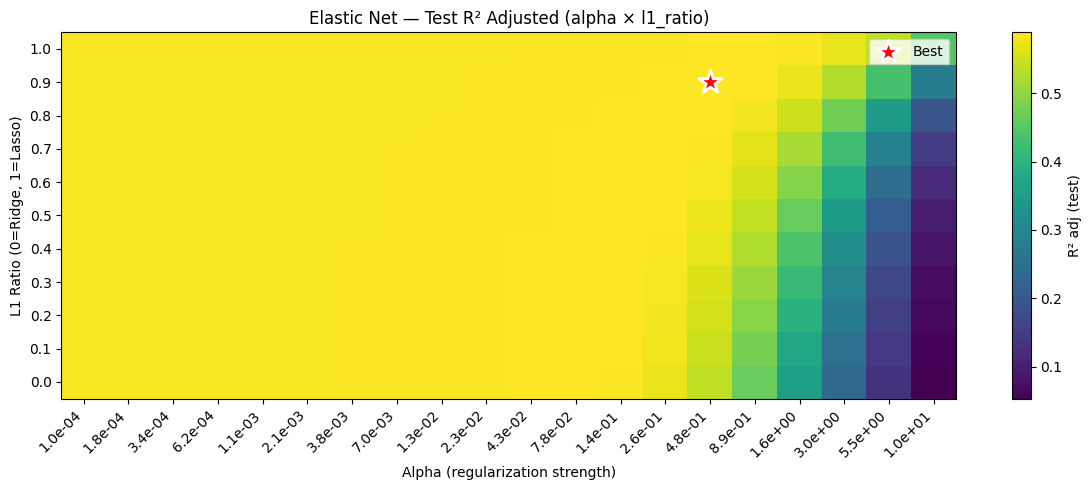


★ Best: α=4.83e-01, l1_ratio=0.9 → R² = 0.5888


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Heatmap of R² across alpha × l1_ratio
# ─────────────────────────────────────────────────────────────────────────────
pivot = res.pivot(index='l1_ratio', columns='alpha', values='r2_adj_test')

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')

# Labels
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([f'{v:.1f}' for v in pivot.index])
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([f'{v:.1e}' for v in pivot.columns], rotation=45, ha='right')

ax.set_xlabel('Alpha (regularization strength)')
ax.set_ylabel('L1 Ratio (0=Ridge, 1=Lasso)')
ax.set_title('Elastic Net — Test R² Adjusted (alpha × l1_ratio)')

# Mark best point
best_row_idx = list(pivot.index).index(best['l1_ratio'])
best_col_idx = list(pivot.columns).index(best['alpha'])
ax.scatter([best_col_idx], [best_row_idx], marker='*', s=300, c='red', edgecolors='white', linewidths=2, label='Best')
ax.legend()

plt.colorbar(im, label='R² adj (test)')
plt.tight_layout()
plt.show()

print(f"\n★ Best: α={best['alpha']:.2e}, l1_ratio={best['l1_ratio']:.1f} → R² = {best['r2_adj_test']:.4f}")

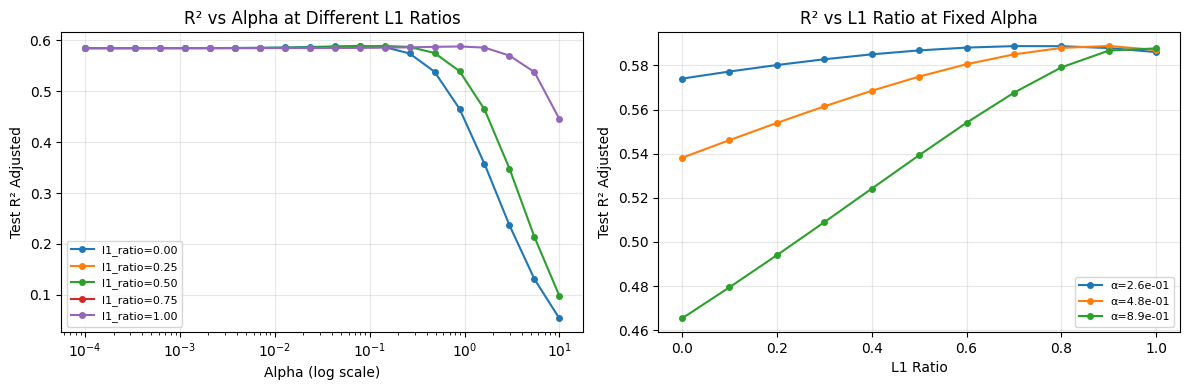

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Cross-sections - R² vs alpha at different l1_ratios
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Fix l1_ratio, vary alpha
for ratio in [0.0, 0.25, 0.5, 0.75, 1.0]:
    subset = res[res['l1_ratio'] == ratio]
    axes[0].semilogx(subset['alpha'], subset['r2_adj_test'], 'o-', label=f'l1_ratio={ratio:.2f}', markersize=4)
axes[0].set_xlabel('Alpha (log scale)')
axes[0].set_ylabel('Test R² Adjusted')
axes[0].set_title('R² vs Alpha at Different L1 Ratios')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Right: Fix alpha (near best), vary l1_ratio
best_alpha_neighbors = res[(res['alpha'] >= best['alpha']/2) & (res['alpha'] <= best['alpha']*2)]
for alpha_val in sorted(best_alpha_neighbors['alpha'].unique())[:5]:
    subset = res[res['alpha'] == alpha_val]
    axes[1].plot(subset['l1_ratio'], subset['r2_adj_test'], 'o-', label=f'α={alpha_val:.1e}', markersize=4)
axes[1].set_xlabel('L1 Ratio')
axes[1].set_ylabel('Test R² Adjusted')
axes[1].set_title('R² vs L1 Ratio at Fixed Alpha')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Conclusions (Elastic Net Only)

### Final Elastic Net Metrics (Best Observed)
- **Best hyperparameters (sweep):** `alpha=0.483293`, `l1_ratio=0.9`
- **Adjusted $R^2$ (train):** $0.664952$
- **Adjusted $R^2$ (test):** $0.588824$
- **Test RMSE:** $21.178360$
- **Non-zero coefficients:** $5/5$

### Key Deductions
1. **Elastic Net behaves like a constrained linear model here.** With only 5 inputs, it cannot represent the strong nonlinear interactions in L/D, so test $R^2_{adj}$ stays around ~0.59 (well below nonlinear models).
2. **Regularization does not induce sparsity here.** Even at high `l1_ratio`, the best model keeps **all 5 coefficients non-zero**, indicating no feature is being “dropped” under this setup.
3. **Performance is relatively insensitive across the grid.** Many `alpha`/`l1_ratio` combinations cluster near the same test $R^2_{adj}$, which suggests model bias (linearity) is the limiting factor, not hyperparameter tuning.